In [59]:
import os
import numpy as np
import collections
import pickle
import h5py

data_dir = "./"
output_dir = "./processed_data"

print(data_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for file_name in os.listdir(data_dir):
    if not file_name.endswith(".hdf5"):
        continue

    file_path = os.path.join(data_dir, file_name)
    output_file_path = os.path.join(output_dir, f"{os.path.splitext(file_name)[0]}.pkl")

    print(f"Processing: {file_name}")

    # Load the dataset
    with h5py.File(file_path, 'r') as f:
        dataset = {key: np.array(f[key]) for key in f.keys()}
        # Metadata is not needed for processing trajectories
        if 'metadata' in dataset:
            del dataset['metadata']

    # Determine the number of samples
    N = dataset['rewards'].shape[0]
    data_ = collections.defaultdict(list)

    episode_step = 0
    paths = []

    for i in range(N):
        # Extract terminal and timeout conditions
        done_bool = bool(dataset['terminals'][i])
        timeout = bool(dataset['timeouts'][i])

        # Accumulate trajectory data
        for k in ['observations', 'next_observations', 'actions', 'rewards', 'terminals']:
            data_[k].append(dataset[k][i])

        # Check if the trajectory has ended
        if done_bool or timeout:
            episode_step = 0
            episode_data = {}
            for k in data_:
                episode_data[k] = np.array(data_[k])
            paths.append(episode_data)
            data_ = collections.defaultdict(list)
        episode_step += 1

    # Compute trajectory statistics
    returns = np.array([np.sum(p['rewards']) for p in paths])
    num_samples = np.sum([p['rewards'].shape[0] for p in paths])
    print(f'Number of samples collected: {num_samples}')
    print(f'Trajectory returns: mean = {np.mean(returns)}, std = {np.std(returns)}, max = {np.max(returns)}, min = {np.min(returns)}')

    # Save trajectories to a pickle file
    with open(output_file_path, 'wb') as f:
        pickle.dump(paths, f)

    print(f"Processed dataset saved to {output_file_path}")


./
Processing: InvertedPendulum-v4-medium.hdf5
Number of samples collected: 999790
Trajectory returns: mean = 211.77505493164062, std = 4.659221172332764, max = 225.0, min = 197.0
Processed dataset saved to ./processed_data/InvertedPendulum-v4-medium.pkl
Processing: InvertedPendulum-v4-stitched.hdf5
Number of samples collected: 1999790
Trajectory returns: mean = 349.5525207519531, std = 299.39093017578125, max = 1000.0, min = 197.0
Processed dataset saved to ./processed_data/InvertedPendulum-v4-stitched.pkl
Processing: offline_data.hdf5
Number of samples collected: 10000
Trajectory returns: mean = 6.060606002807617, std = 3.417595863342285, max = 26.0, min = 3.0
Processed dataset saved to ./processed_data/offline_data.pkl
Processing: InvertedPendulum-v4-stitched-3.hdf5
Number of samples collected: 2009790
Trajectory returns: mean = 272.6617736816406, std = 300.1198425292969, max = 1000.0, min = 3.0
Processed dataset saved to ./processed_data/InvertedPendulum-v4-stitched-3.pkl
Processin

# import libs


In [60]:
import os
import sys
import random
import csv
from datetime import datetime
import pickle
import collections
import math
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# training parameters

In [61]:

dataset = "stitched"       # medium / medium-replay / medium-expert
rtg_scale = 1000                # scale to normalize returns to go


env_name = 'InvertedPendulum-v4'
rtg_target = 10000
env_d4rl_name = f'InvertedPendulum-v4-{dataset}'


max_eval_ep_len = 1000      # max len of one evaluation episode
num_eval_ep = 10            # num of evaluation episodes per iteration

batch_size = 64             # training batch size
lr = 2e-4                   # learning rate
wt_decay = 1e-4             # weight decay
warmup_steps = 10000        # warmup steps for lr scheduler

# total updates = max_train_iters x num_updates_per_iter
max_train_iters = 200
num_updates_per_iter = 1000

context_len = 5        # K in decision transformer
n_blocks = 3            # num of transformer blocks
embed_dim = 128         # embedding (hidden) dim of transformer
n_heads = 1             # num of transformer heads
dropout_p = 0.1         # dropout probability



# load data from this file
dataset_path = f'processed_data/{env_d4rl_name}.pkl'

# saves model and csv in this directory
log_dir = "./dt_runs/"


if not os.path.exists(log_dir):
    os.makedirs(log_dir)


# training and evaluation device
device_name = 'cuda'
device = torch.device(device_name)
print("device set to: ", device)



device set to:  cuda


# decision transformer model

In [62]:

"""
this extremely minimal GPT model is based on:
Misha Laskin's tweet:
https://twitter.com/MishaLaskin/status/1481767788775628801?cxt=HHwWgoCzmYD9pZApAAAA

and its corresponding notebook:
https://colab.research.google.com/drive/1NUBqyboDcGte5qAJKOl8gaJC28V_73Iv?usp=sharing

the above colab has a bug while applying masked_fill which is fixed in the
following code

"""

class MaskedCausalAttention(nn.Module):
    def __init__(self, h_dim, max_T, n_heads, drop_p):
        super().__init__()

        self.n_heads = n_heads
        self.max_T = max_T

        self.q_net = nn.Linear(h_dim, h_dim)
        self.k_net = nn.Linear(h_dim, h_dim)
        self.v_net = nn.Linear(h_dim, h_dim)

        self.proj_net = nn.Linear(h_dim, h_dim)

        self.att_drop = nn.Dropout(drop_p)
        self.proj_drop = nn.Dropout(drop_p)

        ones = torch.ones((max_T, max_T))
        mask = torch.tril(ones).view(1, 1, max_T, max_T)

        # register buffer makes sure mask does not get updated
        # during backpropagation
        self.register_buffer('mask',mask)

    def forward(self, x):
        B, T, C = x.shape # batch size, seq length, h_dim * n_heads

        N, D = self.n_heads, C // self.n_heads # N = num heads, D = attention dim

        # rearrange q, k, v as (B, N, T, D)
        q = self.q_net(x).view(B, T, N, D).transpose(1,2)
        k = self.k_net(x).view(B, T, N, D).transpose(1,2)
        v = self.v_net(x).view(B, T, N, D).transpose(1,2)

        # weights (B, N, T, T)
        weights = q @ k.transpose(2,3) / math.sqrt(D)
        # causal mask applied to weights
        weights = weights.masked_fill(self.mask[...,:T,:T] == 0, float('-inf'))
        # normalize weights, all -inf -> 0 after softmax
        normalized_weights = F.softmax(weights, dim=-1)

        # attention (B, N, T, D)
        attention = self.att_drop(normalized_weights @ v)

        # gather heads and project (B, N, T, D) -> (B, T, N*D)
        attention = attention.transpose(1, 2).contiguous().view(B,T,N*D)

        out = self.proj_drop(self.proj_net(attention))
        return out


class Block(nn.Module):
    def __init__(self, h_dim, max_T, n_heads, drop_p):
        super().__init__()
        self.attention = MaskedCausalAttention(h_dim, max_T, n_heads, drop_p)
        self.mlp = nn.Sequential(
                nn.Linear(h_dim, 4*h_dim),
                nn.GELU(),
                nn.Linear(4*h_dim, h_dim),
                nn.Dropout(drop_p),
            )
        self.ln1 = nn.LayerNorm(h_dim)
        self.ln2 = nn.LayerNorm(h_dim)

    def forward(self, x):
        # Attention -> LayerNorm -> MLP -> LayerNorm
        x = x + self.attention(x) # residual
        x = self.ln1(x)
        x = x + self.mlp(x) # residual
        x = self.ln2(x)
        return x


class DecisionTransformer(nn.Module):
    def __init__(self, state_dim, act_dim, n_blocks, h_dim, context_len,
                 n_heads, drop_p, max_timestep=4096):
        super().__init__()

        self.state_dim = state_dim
        self.act_dim = act_dim
        self.h_dim = h_dim

        ### transformer blocks
        input_seq_len = 3 * context_len
        blocks = [Block(h_dim, input_seq_len, n_heads, drop_p) for _ in range(n_blocks)]
        self.transformer = nn.Sequential(*blocks)

        ### projection heads (project to embedding)
        self.embed_ln = nn.LayerNorm(h_dim)
        self.embed_timestep = nn.Embedding(max_timestep, h_dim)
        self.embed_rtg = torch.nn.Linear(1, h_dim)
        self.embed_state = torch.nn.Linear(state_dim, h_dim)

        # # discrete actions
        # self.embed_action = torch.nn.Embedding(act_dim, h_dim)
        # use_action_tanh = False # False for discrete actions

        # continuous actions
        self.embed_action = torch.nn.Linear(act_dim, h_dim)
        use_action_tanh = True # True for continuous actions

        ### prediction heads
        self.predict_rtg = torch.nn.Linear(h_dim, 1)
        self.predict_state = torch.nn.Linear(h_dim, state_dim)
        self.predict_action = nn.Sequential(
            *([nn.Linear(h_dim, act_dim)] + ([nn.Tanh()] if use_action_tanh else []))
        )


    def forward(self, timesteps, states, actions, returns_to_go):

        B, T, _ = states.shape

        time_embeddings = self.embed_timestep(timesteps)

        # time embeddings are treated similar to positional embeddings
        state_embeddings = self.embed_state(states) + time_embeddings
        action_embeddings = self.embed_action(actions) + time_embeddings
        returns_embeddings = self.embed_rtg(returns_to_go) + time_embeddings

        # stack rtg, states and actions and reshape sequence as
        # (r1, s1, a1, r2, s2, a2 ...)
        h = torch.stack(
            (returns_embeddings, state_embeddings, action_embeddings), dim=1
        ).permute(0, 2, 1, 3).reshape(B, 3 * T, self.h_dim)

        h = self.embed_ln(h)

        # transformer and prediction
        h = self.transformer(h)

        # get h reshaped such that its size = (B x 3 x T x h_dim) and
        # h[:, 0, t] is conditioned on r_0, s_0, a_0 ... r_t
        # h[:, 1, t] is conditioned on r_0, s_0, a_0 ... r_t, s_t
        # h[:, 2, t] is conditioned on r_0, s_0, a_0 ... r_t, s_t, a_t
        h = h.reshape(B, T, 3, self.h_dim).permute(0, 2, 1, 3)

        # get predictions
        return_preds = self.predict_rtg(h[:,2])     # predict next rtg given r, s, a
        state_preds = self.predict_state(h[:,2])    # predict next state given r, s, a
        action_preds = self.predict_action(h[:,1])  # predict action given r, s

        return state_preds, action_preds, return_preds

# utils

In [ ]:
REF_MAX_SCORE = {
    'halfcheetah' : 12135.0,
    'walker2d' : 4592.3,
    'hopper' : 3234.3,
    'invertedpendulum' : 1000.0,
}

REF_MIN_SCORE = {
    'halfcheetah' : -280.178953,
    'walker2d' : 1.629008,
    'hopper' : -20.272305,
    'invertedpendulum' : 3.0,
}

def discount_cumsum(x, gamma):
    disc_cumsum = np.zeros_like(x)
    disc_cumsum[-1] = x[-1]
    for t in reversed(range(x.shape[0]-1)):
        disc_cumsum[t] = x[t] + gamma * disc_cumsum[t+1]
    return disc_cumsum


def get_d4rl_normalized_score(score, env_name):
    env_key = env_name.split('-')[0].lower()
    assert env_key in REF_MAX_SCORE, f'no reference score for {env_key} env to calculate d4rl score'
    return (score - REF_MIN_SCORE[env_key]) / (REF_MAX_SCORE[env_key] - REF_MIN_SCORE[env_key])


def evaluate_on_env(model, device, context_len, env, rtg_target, rtg_scale,
                    num_eval_ep=10, max_test_ep_len=1000,
                    state_mean=None, state_std=None, render=False):

    eval_batch_size = 1  # required for forward pass

    results = {}
    total_reward = 0
    total_timesteps = 0

    state_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]

    if state_mean is None:
        state_mean = torch.zeros((state_dim,)).to(device)
    else:
        state_mean = torch.from_numpy(state_mean).to(device)

    if state_std is None:
        state_std = torch.ones((state_dim,)).to(device)
    else:
        state_std = torch.from_numpy(state_std).to(device)

    # same as timesteps used for training the transformer
    # also, crashes if device is passed to arange()
    timesteps = torch.arange(start=0, end=max_test_ep_len, step=1)
    timesteps = timesteps.repeat(eval_batch_size, 1).to(device)

    model.eval()

    with torch.no_grad():

        for _ in range(num_eval_ep):

            # zeros place holders
            actions = torch.zeros((eval_batch_size, max_test_ep_len, act_dim),
                                dtype=torch.float32, device=device)

            states = torch.zeros((eval_batch_size, max_test_ep_len, state_dim),
                                dtype=torch.float32, device=device)

            rewards_to_go = torch.zeros((eval_batch_size, max_test_ep_len, 1),
                                dtype=torch.float32, device=device)

            # init episode
            running_state,_ = env.reset(seed=12)
            running_reward = 0
            running_rtg = rtg_target / rtg_scale

            for t in range(max_test_ep_len):

                total_timesteps += 1

                # add state in placeholder and normalize
                states[0, t] = torch.from_numpy(running_state).to(device)
                states[0, t] = (states[0, t] - state_mean) / state_std

                # calcualate running rtg and add in placeholder
                running_rtg = running_rtg - (running_reward / rtg_scale)
                rewards_to_go[0, t] = running_rtg

                if t < context_len:
                    _, act_preds, _ = model.forward(timesteps[:,:context_len],
                                                states[:,:context_len],
                                                actions[:,:context_len],
                                                rewards_to_go[:,:context_len])
                    act = act_preds[0, t].detach()
                else:
                    _, act_preds, _ = model.forward(timesteps[:,t-context_len+1:t+1],
                                                states[:,t-context_len+1:t+1],
                                                actions[:,t-context_len+1:t+1],
                                                rewards_to_go[:,t-context_len+1:t+1])
                    act = act_preds[0, -1].detach()


                running_state, running_reward, done, truncations, infos  = env.step(act.cpu().numpy())

                # add action in placeholder
                actions[0, t] = act

                total_reward += running_reward

                if render:
                    env.render()
                if done:
                    break

    results['eval/avg_reward'] = total_reward / num_eval_ep
    results['eval/avg_ep_len'] = total_timesteps / num_eval_ep

    return results



# dataset

In [64]:
## check data

# load dataset
with open(dataset_path, 'rb') as f:
    trajectories = pickle.load(f)

min_len = 10**4
states = []
for traj in trajectories:
    min_len = min(min_len, traj['observations'].shape[0])
    states.append(traj['observations'])

# used for input normalization
states = np.concatenate(states, axis=0)
state_mean, state_std = np.mean(states, axis=0), np.std(states, axis=0) + 1e-6

print(dataset_path)
print("num of trajectories in dataset: ", len(trajectories))
print("minimum trajectory length in dataset: ", min_len)
print("state mean: ", state_mean.tolist())
print("state std: ", state_std.tolist())

processed_data/InvertedPendulum-v4-stitched.pkl
num of trajectories in dataset:  5721
minimum trajectory length in dataset:  197
state mean:  [0.0017522607231512666, -0.005709932651370764, -0.01926964335143566, -0.011516096070408821]
state std:  [0.12814675271511078, 0.01897534169256687, 0.161709263920784, 0.3604785203933716]


In [65]:

class D4RLTrajectoryDataset(Dataset):
    def __init__(self, dataset_path, context_len, rtg_scale):
        self.context_len = context_len

        # load dataset
        with open(dataset_path, 'rb') as f:
            self.trajectories = pickle.load(f)

        # Handle Gymnasium `timeouts`
        for traj in self.trajectories:
            if 'timeouts' in traj:
                traj['terminals'] = np.logical_or(traj['terminals'], traj['timeouts'])

        # calculate min len of traj, state mean and variance
        # and returns_to-go for all traj
        min_len = 10**6
        states = []
        for traj in self.trajectories:
            traj_len = traj['observations'].shape[0]
            min_len = min(min_len, traj_len)
            states.append(traj['observations'])
            # calculate returns-to-go and rescale them
            traj['returns_to_go'] = discount_cumsum(traj['rewards'], 1.0) / rtg_scale

        # used for input normalization
        states = np.concatenate(states, axis=0)
        self.state_mean, self.state_std = np.mean(states, axis=0), np.std(states, axis=0) + 1e-6

        # normalize states
        for traj in self.trajectories:
            traj['observations'] = (traj['observations'] - self.state_mean) / self.state_std

    def get_state_stats(self):
        return self.state_mean, self.state_std

    def __len__(self):
        return len(self.trajectories)

    def __getitem__(self, idx):
        traj = self.trajectories[idx]
        traj_len = traj['observations'].shape[0]

        if traj_len >= self.context_len:
            # sample random index to slice trajectory
            si = random.randint(0, traj_len - self.context_len)

            states = torch.from_numpy(traj['observations'][si : si + self.context_len])
            actions = torch.from_numpy(traj['actions'][si : si + self.context_len])
            returns_to_go = torch.from_numpy(traj['returns_to_go'][si : si + self.context_len])
            timesteps = torch.arange(start=si, end=si+self.context_len, step=1)

            # all ones since no padding
            traj_mask = torch.ones(self.context_len, dtype=torch.long)

        else:
            padding_len = self.context_len - traj_len

            # padding with zeros
            states = torch.from_numpy(traj['observations'])
            states = torch.cat([states,
                                torch.zeros(([padding_len] + list(states.shape[1:])),
                                dtype=states.dtype)],
                               dim=0)

            actions = torch.from_numpy(traj['actions'])
            actions = torch.cat([actions,
                                torch.zeros(([padding_len] + list(actions.shape[1:])),
                                dtype=actions.dtype)],
                               dim=0)

            returns_to_go = torch.from_numpy(traj['returns_to_go'])
            returns_to_go = torch.cat([returns_to_go,
                                torch.zeros(([padding_len] + list(returns_to_go.shape[1:])),
                                dtype=returns_to_go.dtype)],
                               dim=0)

            timesteps = torch.arange(start=0, end=self.context_len, step=1)

            traj_mask = torch.cat([torch.ones(traj_len, dtype=torch.long),
                                   torch.zeros(padding_len, dtype=torch.long)],
                                  dim=0)

        return  timesteps, states, actions, returns_to_go, traj_mask



# train

In [66]:

start_time = datetime.now().replace(microsecond=0)

start_time_str = start_time.strftime("%y-%m-%d-%H-%M-%S")

prefix = "dt_" + env_d4rl_name

save_model_name =  prefix + "_model_" + start_time_str + ".pt"
save_model_path = os.path.join(log_dir, save_model_name)
save_best_model_path = save_model_path[:-3] + "_best.pt"

log_csv_name = prefix + "_log_" + start_time_str + ".csv"
log_csv_path = os.path.join(log_dir, log_csv_name)


csv_writer = csv.writer(open(log_csv_path, 'a', 1))
csv_header = (["duration", "num_updates", "action_loss",
               "eval_avg_reward", "eval_avg_ep_len", "eval_d4rl_score"])

csv_writer.writerow(csv_header)


print("=" * 60)
print("start time: " + start_time_str)
print("=" * 60)

print("device set to: " + str(device))
print("dataset path: " + dataset_path)
print("model save path: " + save_model_path)
print("log csv save path: " + log_csv_path)


traj_dataset = D4RLTrajectoryDataset(dataset_path, context_len, rtg_scale)

traj_data_loader = DataLoader(traj_dataset,
						batch_size=batch_size,
						shuffle=True,
						pin_memory=True,
						drop_last=True)

data_iter = iter(traj_data_loader)

## get state stats from dataset
state_mean, state_std = traj_dataset.get_state_stats()

env = gym.make(env_name)

state_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]

model = DecisionTransformer(
			state_dim=state_dim,
			act_dim=act_dim,
			n_blocks=n_blocks,
			h_dim=embed_dim,
			context_len=context_len,
			n_heads=n_heads,
			drop_p=dropout_p,
		).to(device)

optimizer = torch.optim.AdamW(
					model.parameters(),
					lr=lr,
					weight_decay=wt_decay
				)

scheduler = torch.optim.lr_scheduler.LambdaLR(
		optimizer,
		lambda steps: min((steps+1)/warmup_steps, 1)
	)

max_d4rl_score = -1.0
total_updates = 0

for i_train_iter in range(max_train_iters):

	log_action_losses = []
	model.train()

	for _ in range(num_updates_per_iter):
		try:
			timesteps, states, actions, returns_to_go, traj_mask = next(data_iter)
		except StopIteration:
			data_iter = iter(traj_data_loader)
			timesteps, states, actions, returns_to_go, traj_mask = next(data_iter)

		timesteps = timesteps.to(device)	# B x T
		states = states.to(device)			# B x T x state_dim
		actions = actions.to(device)		# B x T x act_dim
		returns_to_go = returns_to_go.to(device).unsqueeze(dim=-1) # B x T x 1
		traj_mask = traj_mask.to(device)	# B x T

		action_target = torch.clone(actions).detach().to(device)

		state_preds, action_preds, return_preds = model.forward(
														timesteps=timesteps,
														states=states,
														actions=actions,
														returns_to_go=returns_to_go
													)

		# only consider non padded elements
		action_preds = action_preds.view(-1, act_dim)[traj_mask.view(-1,) > 0]
		action_target = action_target.view(-1, act_dim)[traj_mask.view(-1,) > 0]

		action_loss = F.mse_loss(action_preds, action_target, reduction='mean')

		optimizer.zero_grad()
		action_loss.backward()
		torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
		optimizer.step()
		scheduler.step()

		log_action_losses.append(action_loss.detach().cpu().item())

	# evaluate on env
	results = evaluate_on_env(model, device, context_len, env, rtg_target, rtg_scale,
	                        num_eval_ep, max_eval_ep_len, state_mean, state_std,
							)
	eval_avg_reward = results['eval/avg_reward']
	eval_avg_ep_len = results['eval/avg_ep_len']
	eval_d4rl_score = get_d4rl_normalized_score(results['eval/avg_reward'], env_name) * 100

	mean_action_loss = np.mean(log_action_losses)
	time_elapsed = str(datetime.now().replace(microsecond=0) - start_time)

	total_updates += num_updates_per_iter

	log_str = ("=" * 60 + '\n' +
			"time elapsed: " + time_elapsed  + '\n' +
			"num of updates: " + str(total_updates) + '\n' +
			"action loss: " +  format(mean_action_loss, ".5f") + '\n' +
			"eval avg reward: " + format(eval_avg_reward, ".5f") + '\n' +
			"eval avg ep len: " + format(eval_avg_ep_len, ".5f") + '\n' +
			"eval d4rl score: " + format(eval_d4rl_score, ".5f")
			)

	print(log_str)

	log_data = [time_elapsed, total_updates, mean_action_loss,
				eval_avg_reward, eval_avg_ep_len,
				eval_d4rl_score]

	csv_writer.writerow(log_data)

	# save model
	print("max d4rl score: " + format(max_d4rl_score, ".5f"))
	if eval_d4rl_score >= max_d4rl_score:
		print("saving max d4rl score model at: " + save_best_model_path)
		torch.save(model.state_dict(), save_best_model_path)
		max_d4rl_score = eval_d4rl_score

	print("saving current model at: " + save_model_path)
	torch.save(model.state_dict(), save_model_path)


print("=" * 60)
print("finished training!")
print("=" * 60)
end_time = datetime.now().replace(microsecond=0)
time_elapsed = str(end_time - start_time)
end_time_str = end_time.strftime("%y-%m-%d-%H-%M-%S")
print("started training at: " + start_time_str)
print("finished training at: " + end_time_str)
print("total training time: " + time_elapsed)
print("max d4rl score: " + format(max_d4rl_score, ".5f"))
print("saved max d4rl score model at: " + save_best_model_path)
print("saved last updated model at: " + save_model_path)
print("=" * 60)

start time: 24-11-23-09-03-41
device set to: cuda
dataset path: processed_data/InvertedPendulum-v4-stitched.pkl
model save path: ./dt_runs/dt_InvertedPendulum-v4-stitched_model_24-11-23-09-03-41.pt
log csv save path: ./dt_runs/dt_InvertedPendulum-v4-stitched_log_24-11-23-09-03-41.csv
time elapsed: 0:00:19
num of updates: 1000
action loss: 0.20848
eval avg reward: 49.00000
eval avg ep len: 49.00000
eval d4rl score: 4.61384
max d4rl score: -1.00000
saving max d4rl score model at: ./dt_runs/dt_InvertedPendulum-v4-stitched_model_24-11-23-09-03-41_best.pt
saving current model at: ./dt_runs/dt_InvertedPendulum-v4-stitched_model_24-11-23-09-03-41.pt
time elapsed: 0:00:36
num of updates: 2000
action loss: 0.08502
eval avg reward: 57.00000
eval avg ep len: 57.00000
eval d4rl score: 5.41625
max d4rl score: 4.61384
saving max d4rl score model at: ./dt_runs/dt_InvertedPendulum-v4-stitched_model_24-11-23-09-03-41_best.pt
saving current model at: ./dt_runs/dt_InvertedPendulum-v4-stitched_model_24-11

# plots

dt_runs/dt_InvertedPendulum-v4-stitched_log_24-11-22-22-35-34.csv (200, 6)
dt_runs/dt_InvertedPendulum-v4-stitched_log_24-11-23-09-03-41.csv (200, 6)


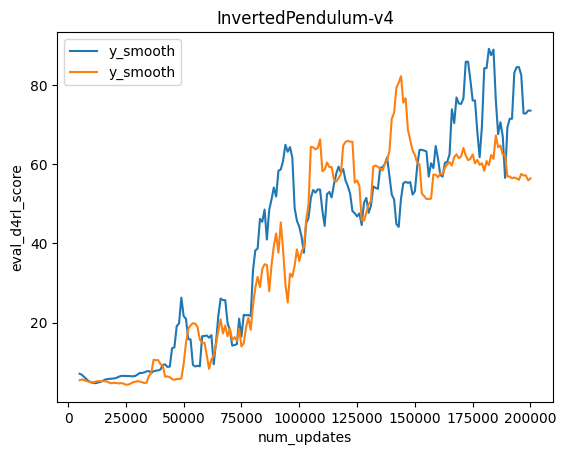

In [70]:
import numpy as np
import pickle

import pandas as pd
import glob

import matplotlib.pyplot as plt


env_d4rl_name = 'InvertedPendulum-v4'
log_dir = 'dt_runs/'

x_key = "num_updates"
y_key = "eval_d4rl_score"
y_smoothing_win = 5
plot_avg = False
save_fig = False

if plot_avg:
    save_fig_path = env_d4rl_name + "_avg.png"
else:
    save_fig_path = env_d4rl_name + ".png"


all_files = glob.glob(log_dir + f'/dt_{env_d4rl_name}*.csv')

ax = plt.gca()
ax.set_title(env_d4rl_name)

if plot_avg:
    name_list = []
    df_list = []
    for filename in all_files:
        frame = pd.read_csv(filename, index_col=None, header=0)
        print(filename, frame.shape)
        frame['y_smooth'] = frame[y_key].rolling(window=y_smoothing_win).mean()
        df_list.append(frame)


    df_concat = pd.concat(df_list)
    df_concat_groupby = df_concat.groupby(df_concat.index)
    data_avg = df_concat_groupby.mean()

    data_avg.plot(x=x_key, y='y_smooth', ax=ax)

    ax.set_xlabel(x_key)
    ax.set_ylabel(y_key)
    # ax.legend(['avg of all runs'], loc='lower right')

    if save_fig:
        plt.savefig(save_fig_path)

    plt.show()


else:
    name_list = []
    for filename in all_files:
        frame = pd.read_csv(filename, index_col=None, header=0)
        print(filename, frame.shape)
        frame['y_smooth'] = frame[y_key].rolling(window=y_smoothing_win).mean()
        frame.plot(x=x_key, y='y_smooth', ax=ax)
        name_list.append(filename.split('/')[-1])

    ax.set_xlabel(x_key)
    ax.set_ylabel(y_key)
    # ax.legend(name_list, loc='lower right')

    if save_fig:
        plt.savefig(save_fig_path)

    plt.show()

